# Importer les bibiothèques nécéssaires

In [1]:
import findspark

findspark.init()

In [2]:
import seaborn as sb

In [3]:
import pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Immobilier').getOrCreate()

from pyspark.ml.regression import LinearRegression

# Importer le jeux de données
Dans notre cas c'est l'immobilier

In [4]:
dataset = spark.read.csv("data/Real estate.csv", inferSchema= True, header = True)

dataset

DataFrame[No: int, X1 transaction date: double, X2 house age: double, X3 distance to the nearest MRT station: double, X4 number of convenience stores: int, X5 latitude: double, X6 longitude: double, Y house price of unit area: double]

In [5]:
dataset.show()

+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
|  1|           2012.917|        32.0|                              84.87882|                             10|   24.98298|   121.54024|                      37.9|
|  2|           2012.917|        19.5|                              306.5947|                              9|   24.98034|   121.53951|                      42.2|
|  3|           2013.583|        13.3|                              561.9845|                              5|   24.98746|   121.54391|                      47.3|
|  4|             2013.5|   

In [6]:
dataset.printSchema()

root
 |-- No: integer (nullable = true)
 |-- X1 transaction date: double (nullable = true)
 |-- X2 house age: double (nullable = true)
 |-- X3 distance to the nearest MRT station: double (nullable = true)
 |-- X4 number of convenience stores: integer (nullable = true)
 |-- X5 latitude: double (nullable = true)
 |-- X6 longitude: double (nullable = true)
 |-- Y house price of unit area: double (nullable = true)



# Le problème à résoudre est une régression linéaire multiple
Nous allons essayer de prédire le prix du metre carré d'une maison en fonction de la date de transaction, l'age de la maison, la distance vers la station de transport la plus proche, le nombre de superettes proches, la latitude et longitude de la maison

In [7]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [8]:
featureassembler=VectorAssembler(inputCols=["X1 transaction date","X2 house age",
                                            "X3 distance to the nearest MRT station","X4 number of convenience stores",
                                            "X5 latitude","X6 longitude"],outputCol="Output")

In [9]:
output=featureassembler.transform(dataset)

In [10]:
output.show()

+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+--------------------+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|              Output|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+--------------------+
|  1|           2012.917|        32.0|                              84.87882|                             10|   24.98298|   121.54024|                      37.9|[2012.917,32.0,84...|
|  2|           2012.917|        19.5|                              306.5947|                              9|   24.98034|   121.53951|                      42.2|[2012.917,19.5,30...|
|  3|           2013.583|        13.3|                              561.9845|        

In [11]:
output.select("Output").show()

+--------------------+
|              Output|
+--------------------+
|[2012.917,32.0,84...|
|[2012.917,19.5,30...|
|[2013.583,13.3,56...|
|[2013.5,13.3,561....|
|[2012.833,5.0,390...|
|[2012.667,7.1,217...|
|[2012.667,34.5,62...|
|[2013.417,20.3,28...|
|[2013.5,31.7,5512...|
|[2013.417,17.9,17...|
|[2013.083,34.8,40...|
|[2013.333,6.3,90....|
|[2012.917,13.0,49...|
|[2012.667,20.4,24...|
|[2013.5,13.2,1164...|
|[2013.583,35.7,57...|
|[2013.25,0.0,292....|
|[2012.75,17.7,350...|
|[2013.417,16.9,36...|
|[2012.667,1.5,23....|
+--------------------+
only showing top 20 rows



In [12]:
output.columns

['No',
 'X1 transaction date',
 'X2 house age',
 'X3 distance to the nearest MRT station',
 'X4 number of convenience stores',
 'X5 latitude',
 'X6 longitude',
 'Y house price of unit area',
 'Output']

In [13]:
finalized_data=output.select("Output","Y house price of unit area")

In [14]:
finalized_data.show()

+--------------------+--------------------------+
|              Output|Y house price of unit area|
+--------------------+--------------------------+
|[2012.917,32.0,84...|                      37.9|
|[2012.917,19.5,30...|                      42.2|
|[2013.583,13.3,56...|                      47.3|
|[2013.5,13.3,561....|                      54.8|
|[2012.833,5.0,390...|                      43.1|
|[2012.667,7.1,217...|                      32.1|
|[2012.667,34.5,62...|                      40.3|
|[2013.417,20.3,28...|                      46.7|
|[2013.5,31.7,5512...|                      18.8|
|[2013.417,17.9,17...|                      22.1|
|[2013.083,34.8,40...|                      41.4|
|[2013.333,6.3,90....|                      58.1|
|[2012.917,13.0,49...|                      39.3|
|[2012.667,20.4,24...|                      23.8|
|[2013.5,13.2,1164...|                      34.3|
|[2013.583,35.7,57...|                      50.5|
|[2013.25,0.0,292....|                      70.1|


# Nous allons diviser nos données
70% pour l'entrainement du model et 30% pour le test du model

In [15]:
train_data,test_data=finalized_data.randomSplit([0.7,0.3])

In [16]:
regressor=LinearRegression(featuresCol='Output', labelCol='Y house price of unit area')
regressor=regressor.fit(train_data)

In [17]:
regressor.coefficients

DenseVector([3.2356, -0.2643, -0.0037, 1.3783, 225.1655, 12.5918])

In [18]:
regressor.intercept

-13625.227300668215

In [19]:
trainingSummary = regressor.summary

In [20]:
trainingSummary.totalIterations

1

In [21]:
trainingSummary.objectiveHistory

[0.0]

In [22]:
trainingSummary.residuals.show()

+--------------------+
|           residuals|
+--------------------+
|   3.821237825014393|
|  -0.676643166968276|
|   1.323356833031724|
|   9.327812095723132|
|  2.1078318076190072|
| -1.3191061148045264|
|   2.207321209834845|
|-0.00762343692476...|
|-0.01232589758837932|
| -1.5898219884093123|
|   2.231296532514534|
| -10.552346194137499|
| -2.6725803364748586|
|  1.9253507006593296|
|  -4.624336073016092|
|  -1.183536342846125|
|    4.44747592649037|
|   2.727756858400241|
| -0.6826307444840509|
|   8.556653451519011|
+--------------------+
only showing top 20 rows



In [23]:
trainingSummary.rootMeanSquaredError

7.669689478376672

In [24]:
trainingSummary.r2

0.6415074995492672

In [25]:
pred_results=regressor.evaluate(test_data)

In [26]:
pred_results.predictions.show(10)

+--------------------+--------------------------+------------------+
|              Output|Y house price of unit area|        prediction|
+--------------------+--------------------------+------------------+
|[2012.667,0.0,185...|                      37.9| 39.17611496126665|
|[2012.667,20.2,21...|                      22.8| 28.64486671024497|
|[2012.667,29.4,45...|                      13.2|11.597690611764847|
|[2012.667,34.5,62...|                      40.3| 40.01815651202196|
|[2012.667,34.9,17...|                      39.7| 41.67490962941156|
|[2012.75,0.0,208....|                      45.7| 44.35606501874099|
|[2012.75,0.0,338....|                      50.8| 50.86612778115523|
|[2012.75,7.8,104....|                      38.4| 43.70089188621023|
|[2012.75,13.5,419...|                      18.6|13.598296433601718|
|[2012.75,14.1,261...|                      21.8|23.576896131002286|
+--------------------+--------------------------+------------------+
only showing top 10 rows



# Nous allons visualiser la différence entre les données réelles et leurs prédictions

In [27]:
Y = pred_results.predictions.select('Y house price of unit area').toPandas()
_Y = pred_results.predictions.select("prediction").toPandas()

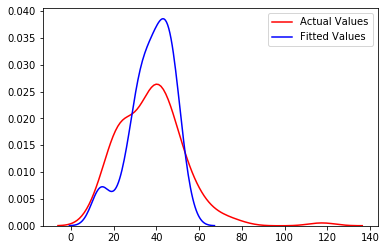

In [28]:
ax1 = sb.distplot(Y, hist=False, color="r", label="Actual Values")
sb.distplot(_Y, hist=False, color="b", label="Fitted Values" , ax=ax1)